# EuroSAT GAN Implementation

This notebook implements a Generative Adversarial Network (GAN) for generating synthetic satellite images based on the EuroSAT dataset. The implementation includes:

- Data loading and preprocessing
- Generator network architecture
- Discriminator network architecture
- Training loop and loss functions
- Visualization of generated images

In [16]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from datetime import datetime, timedelta

In [18]:
# Define dataset path
BATCH_SIZE = 32
dataset_path = 'E:/Datasets/'

# Define transformations for normalization and resizing
transform = transforms.Compose([
    transforms.Resize((64, 64)),           # Resize images to 64x64
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),  # Normalize to [-1, 1] for GAN compatibility
                         (0.5, 0.5, 0.5))
])

# Load dataset
train_dataset = datasets.EuroSAT(root=dataset_path, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


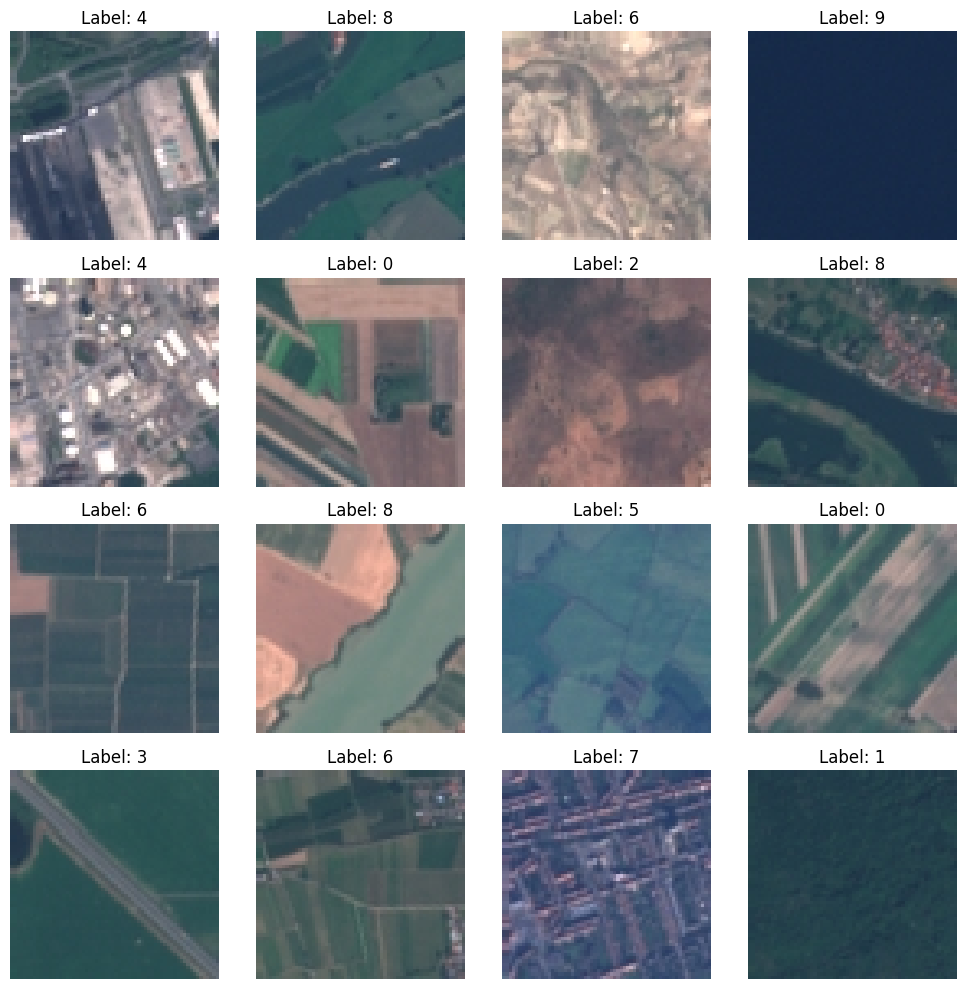

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Randomly select 16 samples from the dataset
indices = np.random.choice(len(train_dataset), 16, replace=False)

for i, index in enumerate(indices):
    image, label = train_dataset[index]  # Access dataset by random index
    image = image.permute(1, 2, 0).numpy()  # Change tensor shape to HWC for display
    image = (image * 0.5) + 0.5  # Unnormalize to range [0, 1] for visualization
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## GAN Implementation

In [22]:
class Generator(nn.Module):
    """
    Creates and returns a generator model for the GAN.

    The generator takes random noise as input and generates synthetic images with dimensions
    of 64x64x3 (matching the EuroSAT dataset).
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Fully connected layer to reshape
            nn.Linear(100, 8 * 8 * 256, bias=False),
            nn.BatchNorm1d(8 * 8 * 256),
            nn.LeakyReLU(0.2, inplace=True),

            # Reshape to 8x8 feature maps
            nn.Unflatten(1, (256, 8, 8)),

            # First upsampling: 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Second upsampling: 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Third upsampling: 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # Final output layer: 64x64x3
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()
generator.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=False)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 8, 8))
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [61]:
class Discriminator(nn.Module):
    """
    Creates and returns a discriminator model for the GAN using PyTorch.

    The discriminator takes 64x64x3 images as input and outputs a binary classification
    (real vs fake).
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.3)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.3)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.3)

        # Fully connected output layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 8 * 8, 1)  # Output: Binary classification (real vs fake)

    def forward(self, x):
        # Pass through first conv layer
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)

        # Pass through second conv layer
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)

        # Pass through third conv layer
        x = self.conv3(x)
        x = self.leaky_relu3(x)
        x = self.dropout3(x)

        # Flatten and pass through fully connected layer
        x = self.flatten(x)
        x = self.fc(x)

        return x

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (dropout3): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)

In [62]:
print("\n===== Generator Summary =====")
summary(generator, input_size=(100,))

print("\n===== Discriminator Summary =====")
summary(discriminator, input_size=(3, 64, 64))


===== Generator Summary =====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16384]       1,638,400
       BatchNorm1d-2                [-1, 16384]          32,768
         LeakyReLU-3                [-1, 16384]               0
         Unflatten-4            [-1, 256, 8, 8]               0
   ConvTranspose2d-5          [-1, 128, 16, 16]         819,200
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         LeakyReLU-7          [-1, 128, 16, 16]               0
   ConvTranspose2d-8           [-1, 64, 32, 32]         204,800
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        LeakyReLU-10           [-1, 64, 32, 32]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]          51,200
      BatchNorm2d-12           [-1, 32, 64, 64]              64
        LeakyReLU-13           [-1, 32, 64, 64]               0
  ConvTr

In [53]:
cross_entropy = nn.BCEWithLogitsLoss()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(real_output, torch.ones_like(real_output))
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(fake_output, torch.ones_like(fake_output))

generator_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

In [54]:
def train_step(images):
    noise = torch.randn(BATCH_SIZE, 100, device=device)

    generator.train()
    discriminator.train()

    # Generate fake images
    generated_images = generator(noise)

    # Calculate discriminator loss
    real_output = discriminator(images)
    fake_output = discriminator(generated_images.detach())
    disc_loss = discriminator_loss(real_output, fake_output)

    # Update discriminator weights
    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()

    # Calculate generator loss
    fake_output = discriminator(generated_images)
    gen_loss = generator_loss(fake_output)

    # Update generator weights
    generator_optimizer.zero_grad()
    gen_loss.backward()
    generator_optimizer.step()

    return gen_loss.item(), disc_loss.item()

In [55]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Fixed random latent vector for visualization
fixed_noise = torch.randn(num_examples_to_generate, noise_dim, device=device)

def train(dataset, epochs):
    start_time = time.time()

    # Initialize lists to store losses for plotting
    gen_losses = []
    disc_losses = []

    # Create progress bar for epochs
    epoch_progress = tqdm(range(epochs), desc='Training Progress')

    for epoch in epoch_progress:
        batch_gen_losses = []
        batch_disc_losses = []

        # Create progress bar for batches
        batch_progress = tqdm(dataset, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for image_batch, _ in batch_progress:  # PyTorch dataset loader provides images and labels
            image_batch = image_batch.to(device)

            # Train discriminator
            noise = torch.randn(image_batch.size(0), noise_dim, device=device)
            fake_images = generator(noise)
            real_labels = torch.ones(image_batch.size(0), 1, device=device)
            fake_labels = torch.zeros(image_batch.size(0), 1, device=device)

            # Compute discriminator loss
            real_output = discriminator(image_batch)
            fake_output = discriminator(fake_images.detach())
            real_loss = cross_entropy(real_output, real_labels)
            fake_loss = cross_entropy(fake_output, fake_labels)
            disc_loss = real_loss + fake_loss

            # Update discriminator weights
            discriminator_optimizer.zero_grad()
            disc_loss.backward()
            discriminator_optimizer.step()

            # Train generator
            noise = torch.randn(image_batch.size(0), noise_dim, device=device)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images)
            gen_loss = cross_entropy(fake_output, real_labels)

            # Update generator weights
            generator_optimizer.zero_grad()
            gen_loss.backward()
            generator_optimizer.step()

            # Record batch losses
            batch_gen_losses.append(gen_loss.item())
            batch_disc_losses.append(disc_loss.item())

            # Update batch progress
            batch_progress.set_postfix({
                'Gen Loss': f'{gen_loss.item():.4f}',
                'Disc Loss': f'{disc_loss.item():.4f}'
            })

        # Calculate average losses for this epoch
        avg_gen_loss = sum(batch_gen_losses) / len(batch_gen_losses)
        avg_disc_loss = sum(batch_disc_losses) / len(batch_disc_losses)
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        # Calculate time metrics
        elapsed_time = time.time() - start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        estimated_time_remaining = avg_time_per_epoch * (epochs - epoch - 1)

        # Update epoch progress bar with detailed metrics
        epoch_progress.set_postfix({
            'Gen Loss': f'{avg_gen_loss:.4f}',
            'Disc Loss': f'{avg_disc_loss:.4f}',
            'Elapsed': str(timedelta(seconds=int(elapsed_time))),
            'Remaining': str(timedelta(seconds=int(estimated_time_remaining))),
            'Progress': f'{((epoch + 1) / epochs) * 100:.1f}%'
        })

        # Save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generator.eval()  # Set generator to evaluation mode
            with torch.no_grad():  # Disable gradient calculations for evaluation
                generate_and_save_images(generator, epoch + 1, fixed_noise)
            generator.train()  # Set generator back to training mode

            # Print detailed summary
            print(f'\nEpoch {epoch + 1}/{epochs} Summary:')
            print(f'Average Generator Loss: {avg_gen_loss:.4f}')
            print(f'Average Discriminator Loss: {avg_disc_loss:.4f}')
            print(f'Time Elapsed: {str(timedelta(seconds=int(elapsed_time)))}')
            print(f'Estimated Time Remaining: {str(timedelta(seconds=int(estimated_time_remaining)))}')
            print(f'Training Progress: {((epoch + 1) / epochs) * 100:.1f}%')
            print(f'Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n')

    # Return losses for plotting
    return gen_losses, disc_losses

In [56]:
def plot_training_progress(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [57]:
def generate_and_save_images(model, epoch, test_input):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        predictions = model(test_input.to(device)).cpu()  # Move input to device and model output to CPU

    predictions = (predictions * 0.5 + 0.5).clamp(0, 1)  # Scale back to [0,1] and clamp values

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].permute(1, 2, 0).numpy())  # Rearrange dimensions for visualization
        plt.axis('off')

    plt.savefig(f'eurosat_gan_epoch_{epoch:04d}.png')
    plt.close()

In [58]:
gen_losses, disc_losses = train(train_dataset, epochs=EPOCHS)
print("Training complete!")
plot_training_progress(gen_losses, disc_losses)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


ValueError: expected 4D input (got 3D input)

NameError: name 'image_batch' is not defined